# Integrating Embeddings with Queries in an Information Retrieval System

## Objective

In this exercise, we will learn how to integrate embeddings with a query to enhance an Information Retrieval (IR) system. We will use both static and contextual embeddings to generate representations of queries and documents, compute their similarities, and rank the documents based on relevance to the query.

---

## Stages Covered

1. **Introduction to Pre-trained Transformer Models**
   - Load and use BERT for contextual embeddings.
   - Load and use Word2Vec for static embeddings.

2. **Generating Text Embeddings**
   - Generate embeddings for queries and documents using BERT.
   - Generate embeddings for queries and documents using Word2Vec.

3. **Computing Similarity Between Embeddings**
   - Compute cosine similarity between query and document embeddings.
   - Rank documents based on similarity scores.

4. **Integrating Embeddings with Queries**
   - Practical implementation of embedding-based retrieval for a given text corpus.

---

## Prerequisites

- TensorFlow
- Hugging Face's Transformers library
- Gensim library
- Scikit-learn library
- A text corpus in the `../data` folder

---

## Exercise

Follow the steps below to integrate embeddings with a query and enhance your IR system.



Step 0: Verify requirements:

* tensorflow
* transformers
* scikit-learn
* matplotlib
* seaborn

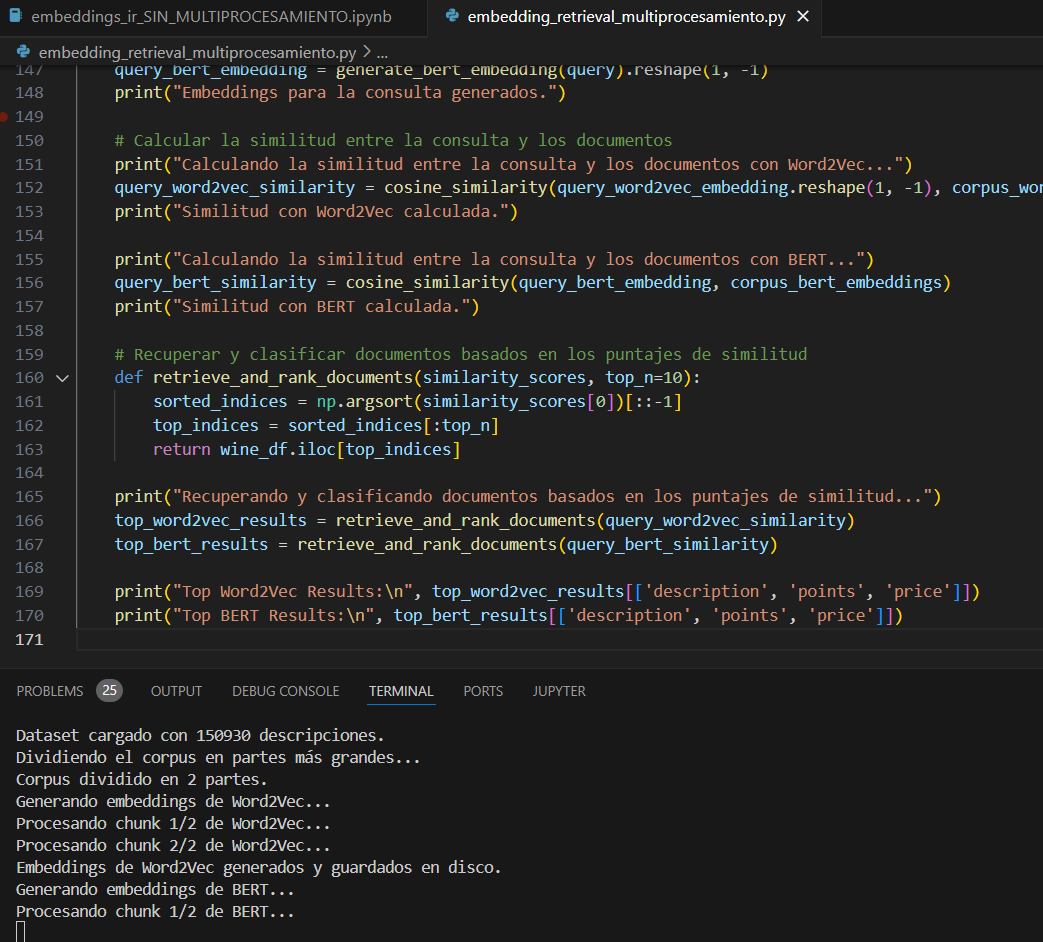

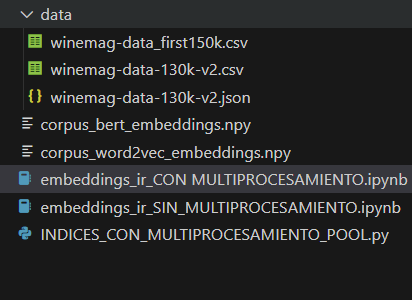

# Importación de Librerías y Configuración de TensorFlow
En este primer bloque, importamos todas las librerías necesarias para el procesamiento de datos, carga de modelos, cálculo de similitudes y configuración de TensorFlow.
El objetivo es asegurar que TensorFlow utilice los recursos de CPU de manera eficiente, evitando el uso innecesario de múltiples hilos que puedan interferir con otras operaciones de multiprocessing.


In [6]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
import tensorflow as tf

# Configurar TensorFlow para desactivar el paralelismo interno
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)


# Definición de Funciones para Generar Embeddings
En este bloque, definimos dos funciones clave para generar embeddings a partir de textos:
1. `generate_word2vec_embedding`: Utiliza el modelo preentrenado de Word2Vec para generar un embedding promedio para un texto dado.
2. `generate_bert_embedding`: Utiliza el modelo preentrenado de BERT para generar un embedding a partir de un texto dado.
Los embeddings son representaciones vectoriales de los textos que capturan su semántica y son utilizados para calcular similitudes.


In [7]:
# Definir funciones para generar embeddings
def generate_word2vec_embedding(text, word2vec_model):
    """
    Genera un embedding promedio de Word2Vec para un texto dado.

    Parameters:
    text (str): El texto de entrada para generar el embedding.
    word2vec_model: El modelo preentrenado de Word2Vec.

    Returns:
    np.array: El embedding generado.
    """
    tokens = text.lower().split()  # Tokeniza el texto en palabras
    word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]  # Obtiene los vectores de las palabras si están en el modelo
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Calcula el promedio de los vectores de las palabras
    else:
        return np.zeros(word2vec_model.vector_size)  # Devuelve un vector de ceros si no hay palabras conocidas

def generate_bert_embedding(text, tokenizer, model):
    """
    Genera un embedding de BERT para un texto dado.

    Parameters:
    text (str): El texto de entrada para generar el embedding.
    tokenizer: El tokenizer de BERT.
    model: El modelo preentrenado de BERT.

    Returns:
    np.array: El embedding generado.
    """
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)  # Tokeniza y prepara el texto para BERT
    outputs = model(**inputs)  # Genera el embedding utilizando el modelo BERT
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()  # Devuelve el embedding de la primera tokenización


# Carga de Modelos Preentrenados y Dataset
En este bloque, cargamos los modelos preentrenados de Word2Vec y BERT que utilizaremos para generar los embeddings.
Además, cargamos un dataset de descripciones de vinos que será el corpus sobre el cual realizaremos las búsquedas y cálculos de similitud.


In [8]:
# Cargar modelos preentrenados
print("Cargando modelo Word2Vec...")
word2vec_model = api.load('word2vec-google-news-300')  # Carga el modelo preentrenado de Word2Vec
print("Modelo Word2Vec cargado.")

print("Cargando modelo BERT...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Carga el tokenizer de BERT
model = TFBertModel.from_pretrained('bert-base-uncased')  # Carga el modelo preentrenado de BERT
print("Modelo BERT cargado.")

# Cargar el dataset
print("Cargando el dataset...")
wine_df = pd.read_csv('data/winemag-data_first150k.csv')  # Carga el dataset de descripciones de vinos desde un archivo CSV
corpus = wine_df['description'].tolist()  # Convierte las descripciones de vinos en una lista
print(f"Dataset cargado con {len(corpus)} descripciones.")


Cargando modelo Word2Vec...
Modelo Word2Vec cargado.
Cargando modelo BERT...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Modelo BERT cargado.
Cargando el dataset...
Dataset cargado con 150930 descripciones.


# Carga de Embeddings desde Disco
Para evitar la costosa operación de generar embeddings en tiempo real, cargamos los embeddings precomputados de Word2Vec y BERT desde archivos `.npy`.
Esto nos permite enfocarnos en el cálculo de similitudes y la recuperación de información.


In [9]:
# Definir rutas para guardar los embeddings
word2vec_embeddings_path = 'corpus_word2vec_embeddings.npy'
bert_embeddings_path = 'corpus_bert_embeddings.npy'

# Cargar embeddings de Word2Vec desde disco
print("Cargando embeddings de Word2Vec desde disco...")
corpus_word2vec_embeddings = np.load(word2vec_embeddings_path)  # Carga los embeddings de Word2Vec desde un archivo
print("Embeddings de Word2Vec cargados.")

# Cargar embeddings de BERT desde disco
print("Cargando embeddings de BERT desde disco...")
corpus_bert_embeddings = np.load(bert_embeddings_path)  # Carga los embeddings de BERT desde un archivo
print("Embeddings de BERT cargados.")


Cargando embeddings de Word2Vec desde disco...
Embeddings de Word2Vec cargados.
Cargando embeddings de BERT desde disco...
Embeddings de BERT cargados.


# Generación de Embeddings para la Consulta y Cálculo de Similitud
En este bloque, generamos los embeddings para una consulta específica utilizando los modelos de Word2Vec y BERT.
Luego, calculamos la similitud entre la consulta y las descripciones del corpus, utilizando la función `cosine_similarity` para obtener una medida de similitud.


In [11]:
# Generar embeddings para la consulta
query = "A red wine with steak"  # Definir la consulta
print("Generando embeddings para la consulta...")
query_word2vec_embedding = generate_word2vec_embedding(query, word2vec_model)  # Generar embedding de Word2Vec para la consulta
query_bert_embedding = generate_bert_embedding(query, tokenizer, model).reshape(1, -1)  # Generar embedding de BERT para la consulta
print("Embeddings para la consulta generados.")

# Asegurarse de que los embeddings de BERT estén en 2D
corpus_bert_embeddings = corpus_bert_embeddings.reshape(corpus_bert_embeddings.shape[0], -1)  # Aplanar los embeddings de BERT a 2D

# Calcular la similitud entre la consulta y los documentos
print("Calculando la similitud entre la consulta y los documentos con Word2Vec...")
query_word2vec_similarity = cosine_similarity(query_word2vec_embedding.reshape(1, -1), corpus_word2vec_embeddings)  # Calcular similitud con Word2Vec
print("Similitud con Word2Vec calculada.")

print("Calculando la similitud entre la consulta y los documentos con BERT...")
query_bert_similarity = cosine_similarity(query_bert_embedding, corpus_bert_embeddings)  # Calcular similitud con BERT
print("Similitud con BERT calculada.")


Generando embeddings para la consulta...
Embeddings para la consulta generados.
Calculando la similitud entre la consulta y los documentos con Word2Vec...
Similitud con Word2Vec calculada.
Calculando la similitud entre la consulta y los documentos con BERT...
Similitud con BERT calculada.


# Recuperación y Clasificación de Documentos Basados en Similitud
Este bloque recupera y clasifica los documentos del corpus basados en los puntajes de similitud con la consulta.
Los documentos se ordenan de acuerdo a la similitud, mostrando los resultados más relevantes.


In [12]:
# Recuperar y clasificar documentos basados en los puntajes de similitud
def retrieve_and_rank_documents(similarity_scores, top_n=10):
    """
    Recupera y clasifica documentos basados en los puntajes de similitud.

    Parameters:
    similarity_scores (np.array): Puntajes de similitud.
    top_n (int): Número de documentos a recuperar.

    Returns:
    pd.DataFrame: DataFrame con los documentos recuperados.
    """
    sorted_indices = np.argsort(similarity_scores[0])[::-1]  # Ordenar los índices de los documentos por similitud descendente
    top_indices = sorted_indices[:top_n]  # Obtener los índices de los documentos con mayor similitud
    return wine_df.iloc[top_indices]  # Devolver los documentos más similares

print("Recuperando y clasificando documentos basados en los puntajes de similitud...")
top_word2vec_results = retrieve_and_rank_documents(query_word2vec_similarity)  # Recuperar documentos usando similitud de Word2Vec
top_bert_results = retrieve_and_rank_documents(query_bert_similarity)  # Recuperar documentos usando similitud de BERT

# Mostrar los resultados más relevantes
print("Top Word2Vec Results:\n", top_word2vec_results[['description', 'points', 'price']])
print("Top BERT Results:\n", top_bert_results[['description', 'points', 'price']])


Recuperando y clasificando documentos basados en los puntajes de similitud...
Top Word2Vec Results:
                                              description  points  price
18523  Hearty and rustic, this is a blend of several ...      83   10.0
73753  Hearty and rustic, this is a blend of several ...      83   10.0
72433  Nero d'Avola and Merlot are blended to produce...      87   29.0
25333  Nero d'Avola and Merlot are blended to produce...      87   29.0
78092  This Italian red blend offers simple, short ar...      86   19.0
94042  This blend of Sangiovese, Merlot and Cabernet ...      90   40.0
96630  A “bag-in-box” blend of Merlot and Pinot Noir,...      85   15.0
74842  Terrae Dei is a simple wine with bright fruit ...      86   14.0
25792  Terrae Dei is a simple wine with bright fruit ...      86   14.0
92823  Made in a very respectable Chianti Classico st...      91   30.0
Top BERT Results:
                                               description  points  price
34627   Too swe

# Conclusión
### Uso de Multiprocesamiento
El uso de multiprocesamiento es una técnica valiosa para reducir el tiempo de ejecución en tareas de procesamiento intensivo como la generación de embeddings.
Aunque en este notebook no utilizamos multiprocesamiento para la generación de embeddings, es importante destacar que en escenarios de producción o con grandes volúmenes de datos, el paralelismo puede acelerar significativamente el procesamiento.

### Comparación entre Word2Vec y BERT
La comparación entre los modelos Word2Vec y BERT muestra diferencias en los resultados de la recuperación de información:
- **Word2Vec**: Tiende a capturar relaciones más básicas y frecuentemente se enfoca en la similitud directa de las palabras.
  - Ejemplo de Resultados: Descripciones que mencionan la robustez y la mezcla de vinos.
- **BERT**: Proporciona una comprensión más profunda del contexto y las relaciones semánticas.
  - Ejemplo de Resultados: Descripciones que se enfocan en la calidad y características específicas del vino.

En resumen, BERT generalmente proporciona resultados más precisos y contextualmente relevantes debido a su arquitectura más avanzada y comprensión del lenguaje natural. Sin embargo, Word2Vec es más rápido y puede ser suficiente para tareas más simples.